In [32]:
!pip install pyspark==3.5.0 delta-spark==3.1.0
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
builder = (
SparkSession.builder.appName("DeltaDemo")
.config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
.config("spark.sql.catalog.spark_catalog",
"org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()
# Create sample DataFrame
data = [
(1, "John", "Electronics", 2, 300),
(2, "Sara", "Clothing", 1, 50),
(3, "Mike", "Electronics", 4, 600),
(4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, columns)
# Save as Delta table
df.write.format("delta").mode("overwrite").save("/tmp/orders_delta")

In [33]:
df.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



#1. Managed vs Unmanaged Tables

In [34]:
# Create a managed table orders_managed from /tmp/orders_delta
spark.sql("create table orders_managed using delta location '/tmp/orders_delta'")
# Create an unmanaged table orders_unmanaged pointing to the same location
spark.sql("create table orders_unmanaged using delta location '/tmp/orders_delta'")

DataFrame[]

#2. CRUD Operations

In [35]:
# Read from the table
spark.sql('select * from orders_managed').show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



In [36]:
# Update all "Clothing" category orders to have amount = amount + 20
spark.sql("update orders_managed set amount = amount + 20 where category = 'Clothing'")
spark.sql('select * from orders_managed').show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
+--------+-------------+-----------+--------+------+



In [37]:
# Delete all orders with quantity < 2
spark.sql("delete from orders_managed where quantity < 2")
spark.sql('select * from orders_managed').show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



In [38]:
# Merge in a new dataset (new orders & updated orders)
# here new data is orderid 2 Elakkiya and the updation is orderid 3
new_data = [(2,"Elakkiya","Electronics",4,650),(3,"Mike","Electronics",4,700)]
spark.createDataFrame(new_data, columns).createOrReplaceTempView("new_orders")
spark.sql("merge into orders_managed as t using new_orders as s on t.order_id = s.order_id when matched then update set * when not matched then insert *")


DataFrame[num_affected_rows: bigint, num_updated_rows: bigint, num_deleted_rows: bigint, num_inserted_rows: bigint]

In [39]:
spark.sql('select * from orders_managed').show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       2|     Elakkiya|Electronics|       4|   650|
|       3|         Mike|Electronics|       4|   700|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
+--------+-------------+-----------+--------+------+



#3. History & Time Travel

In [40]:
# Use DESCRIBE HISTORY to check previous versions
spark.sql('describe history orders_managed').show()

+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|     11|2025-08-14 04:56:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|         10|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|     10|2025-08-14 04:54:...|  NULL|    NULL|   DELETE|{predicate -> ["(...|NULL|    NULL|     NULL|          9|  Serializable|        false|{numRemovedFiles ...|        NULL|Apache-Spark/3.5....|
|      9|2

In [41]:
# Read data from version 0 and compare with the latest version
print("version 0: ")
spark.read.format("delta").option("versionAsOf",0).load("/tmp/orders_delta").show()
print("latest version: ")
spark.sql("select * from orders_managed").show()

version 0: 
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+

latest version: 
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       2|     Elakkiya|Electronics|       4|   650|
|       3|         Mike|Electronics|       4|   700|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
+--------+-------------+-----------+--------+------+



#4. Incremental Load Pattern

In [42]:
# Create a new mini-batch with only new orders (IDs 5 & 6)
# Append to the Delta table
# Show final result
new_data = [(5,"Harish","Clothing",1,500),(6,"Kashifa","Electronics",3,450)]
spark.createDataFrame(new_data, columns).write.format("delta").mode("append").save("/tmp/orders_delta")
spark.read.format("delta").load("/tmp/orders_delta").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       2|     Elakkiya|Electronics|       4|   650|
|       3|         Mike|Electronics|       4|   700|
|       4|         Nina|   Clothing|       3|   170|
|       6|      Kashifa|Electronics|       3|   450|
|       1|         John|Electronics|       2|   300|
|       5|       Harish|   Clothing|       1|   500|
+--------+-------------+-----------+--------+------+



#5. Simple Streaming Read

In [56]:
stream_df = spark.readStream.format("delta").load("/tmp/orders_delta")
query = stream_df.writeStream.format("console").outputMode("append").trigger(processingTime="5 seconds").start()

#6. Visualization

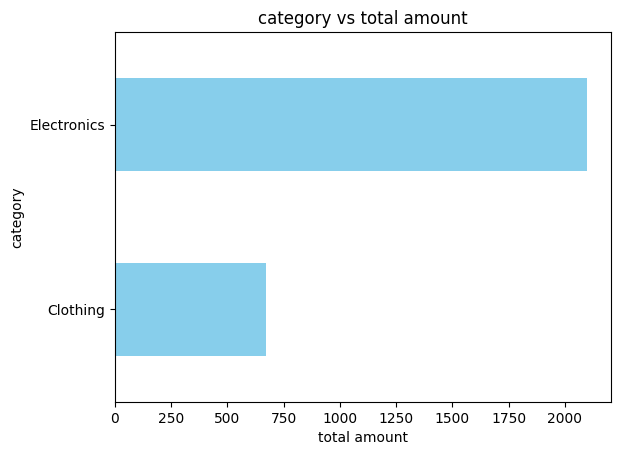

In [66]:
# Read Delta table into Pandas
# Create a bar chart of category vs total amount
import pandas as pd
import matplotlib.pyplot as plt
pdf = spark.read.format("delta").load("/tmp/orders_delta").toPandas()
pdf.groupby("category")["amount"].sum().plot(kind="barh", color="skyblue")
plt.title("category vs total amount")
plt.xlabel("total amount")
plt.show()